In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS, Transformer
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from shapely import LineString, Point

In [2]:
df1 = pd.read_csv('snowstorm_PA.tsv', delimiter='\t')
df2 = pd.read_csv('PA_cities_counties.tsv', delimiter='\t')

In [3]:
df1.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18"""
0,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%
1,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%
2,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%
3,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%
4,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%


In [4]:
df2.head()

,Name,Type,County,Class,Population (2018 Estimates),Incorporation date (as city),Sq Miles
0,Aliquippa,City,Beaver,Third,8908,1987,4.19
1,Allentown,City,Lehigh,Third,123828,1867,17.55
2,Altoona,City,Blair,Third,43702,1868,9.91
3,Arnold,City,Westmoreland,Third,4980,1939,0.73
4,Beaver Falls,City,Beaver,Third,8387,1928,2.13


In [5]:
# Functios from lecture notes / github

def add_area_and_label_coords(some_gdf):
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]

def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                         horizontalalignment='center')

def calc_overall_centroid(some_gdf):
    """
    Use the 'coords' and 'area' columns to estimate an overall centroid
    """
    sum_x = 0.0
    sum_y = 0.0
    sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    centroid_x = sum_x / sum_area
    centroid_y = sum_y / sum_area
    return centroid_x, centroid_y

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).  All args
    must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [32]:
county = gpd.read_file('tl_2021_us_county.zip')
pa_mun = gpd.read_file('PaMunicipalities2022_01.zip')

In [7]:
county[county['STATEFP']=='42'].count() # Data sanity check

STATEFP     67
COUNTYFP    67
COUNTYNS    67
GEOID       67
NAME        67
NAMELSAD    67
LSAD        67
CLASSFP     67
MTFCC       67
CSAFP       40
CBSAFP      54
METDIVFP     6
FUNCSTAT    67
ALAND       67
AWATER      67
INTPTLAT    67
INTPTLON    67
geometry    67
dtype: int64

In [34]:
# Orthographic projection
county = county[county['STATEFP']=='42']

add_area_and_label_coords(county)
lon, lat = calc_overall_centroid(county)
ortho = CRS.from_proj4("+proj=ortho +lat_0={} +lon_0={} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs".format(lat, lon))
ortho = county.to_crs(ortho)
ortho.crs

C:\Users\reyme\AppData\Local\Temp\ipykernel_5016\3989758522.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area


<Projected CRS: +proj=ortho +lat_0=40.900430189750736 +lon_0=-77.8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: Unknown based on Normal Sphere (r=6370997) ellipsoid
- Ellipsoid: Normal Sphere (r=6370997)
- Prime Meridian: Greenwich

In [9]:
# Merging snowfall dataset with counties
snowfall = pd.merge(df1,df2,how='outer',left_on='Location',right_on='Name')
snowfall.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18""",Name,Type,County,Class,Population (2018 Estimates),Incorporation date (as city),Sq Miles
0,Aleppo,7.0,11.0,15.0,100%,100%,99%,97%,92%,79%,37%,1%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aliquippa,9.0,12.0,16.0,100%,100%,100%,99%,97%,90%,52%,3%,Aliquippa,City,Beaver,Third,8908.0,1987.0,4.19
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allentown,City,Lehigh,Third,123828.0,1867.0,17.55
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Altoona,City,Blair,Third,43702.0,1868.0,9.91
4,Ambridge,9.0,12.0,16.0,100%,100%,100%,99%,97%,90%,53%,3%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
snowfall['City'] = np.where((snowfall['Location'].isna()), snowfall['Name'], snowfall['Location'])
snowfall = snowfall[['City','County','Expected Snowfall']]
snowfall.head()

,City,County,Expected Snowfall
0,Aleppo,NaN,11.0
1,Aliquippa,Beaver,12.0
2,Allentown,Lehigh,NaN
3,Altoona,Blair,NaN
4,Ambridge,NaN,12.0


In [11]:
snowfall['County'].isna().count() # No of cities without corresponding counties

np.int64(136)

In [12]:
# Finding missing counties

geolocator = Nominatim(user_agent="my_agent")

def get_county_with_timeout(city, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(f"{city}, Pennsylvania, US", timeout=10)
            if location:
                address = str(location.raw['display_name'])
                parts = address.split(', ')
                for part in parts:
                    if 'County' in part:
                        return part.replace(' County', '').strip()
            return None
        except GeocoderTimedOut:
            print(f"Timeout occurred for {city}. Retrying...")
            retries += 1
            time.sleep(2)  # Wait for 2 seconds before retrying
    print(f"Failed to geocode {city} after {max_retries} attempts.")
    return None

missing_county_mask = snowfall['County'].isna()

snowfall.loc[missing_county_mask, 'County'] = snowfall.loc[missing_county_mask, 'City'].apply(get_county_with_timeout)


In [13]:
snowfall.head(15)

,City,County,Expected Snowfall
0,Aleppo,Greene,11.0
1,Aliquippa,Beaver,12.0
2,Allentown,Lehigh,NaN
3,Altoona,Blair,NaN
4,Ambridge,Beaver,12.0
5,Amity,Washington,11.0
6,Apollo,Armstrong,9.0
7,Armagh,Indiana,8.0
8,Arnold,Westmoreland,NaN
9,Beaver Falls,Beaver,13.0


In [14]:
snowfall = snowfall.groupby('County')['Expected Snowfall'].mean()
snowfall = snowfall.reset_index()

In [15]:
snowfall.head()

,County,Expected Snowfall
0,Allegheny,11.571429
1,Armstrong,9.500000
2,Beaver,12.400000
3,Berks,NaN
4,Blair,NaN


In [16]:
snow_geo = ortho.merge(snowfall,right_on='County',left_on='NAME',how='outer')

In [17]:
snow_geo.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'area', 'coords',
       'County', 'Expected Snowfall'],
      dtype='object')

In [18]:
snow_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area,coords,County,Expected Snowfall
0,42,001,01213656,42001,Adams,Adams County,06,H1,G4020,276,...,A,1.343401e+09,7771555.0,+39.8694707,-077.2177296,"POLYGON ((68175.587 -130947.098, 67841.522 -13...",0.142240,"(-77.22601862229438, 39.8948805)",NaN,NaN
1,42,003,01213657,42003,Allegheny,Allegheny County,06,H1,G4020,430,...,A,1.890572e+09,37043982.0,+40.4697574,-079.9804515,"POLYGON ((-169690.815 -74970.825, -169776.282 ...",0.204690,"(-80.00606401714286, 40.4350505)",Allegheny,11.571429
2,42,005,01213658,42005,Armstrong,Armstrong County,06,H1,G4020,430,...,A,1.692094e+09,27586728.0,+40.8123805,-079.4641285,"POLYGON ((-144434.967 -31784.134, -144428.312 ...",0.183536,"(-79.45349114381392, 40.847128)",Armstrong,9.500000
3,42,007,01214112,42007,Beaver,Beaver County,06,H1,G4020,430,...,A,1.125855e+09,24162295.0,+40.6841401,-080.3507209,"POLYGON ((-205918.654 -37572.414, -207086.806 ...",0.122502,"(-80.33356401630434, 40.6665865)",Beaver,12.400000
4,42,009,01209171,42009,Bedford,Bedford County,06,H1,G4020,None,...,A,2.621693e+09,12005858.0,+39.9986336,-078.4947466,"POLYGON ((-55836.871 -130721.809, -56062.381 -...",0.277795,"(-78.48301079686838, 40.0247535)",NaN,NaN


<Axes: >

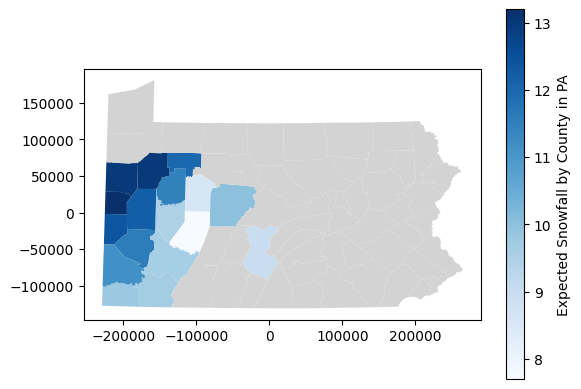

In [19]:
snow_geo.plot(column='Expected Snowfall', cmap='Blues', missing_kwds={"color": "lightgrey"},
              legend=True, legend_kwds={"label": 'Expected Snowfall by County in PA'})

In [35]:
# Travel loop
travel_towns = ['PITTSBURGH','SCRANTON','ALLENTOWN','PHILADELPHIA','HARRISBURG','PITTSBURGH']
pa_mun = pa_mun[pa_mun["MUNICIPAL1"].isin(travel_towns)]

In [41]:
# Orthographic Projection
county_ortho = county.to_crs(ortho.crs)
travel_ortho = pa_mun.to_crs(ortho.crs)

# Fetching representative points for plotting
travel_ortho["coords"] = travel_ortho["geometry"].apply(lambda x: x.representative_point().coords[:])
travel_ortho["coords"] = [coords[0] for coords in travel_ortho["coords"]]

In [42]:
# Plante Carree projection
plate_carree = CRS.from_proj4("+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
plate_carree_mun = pa_mun.to_crs(plate_carree)
plate_carree_mun.crs
add_area_and_label_coords(pa_mun)
 

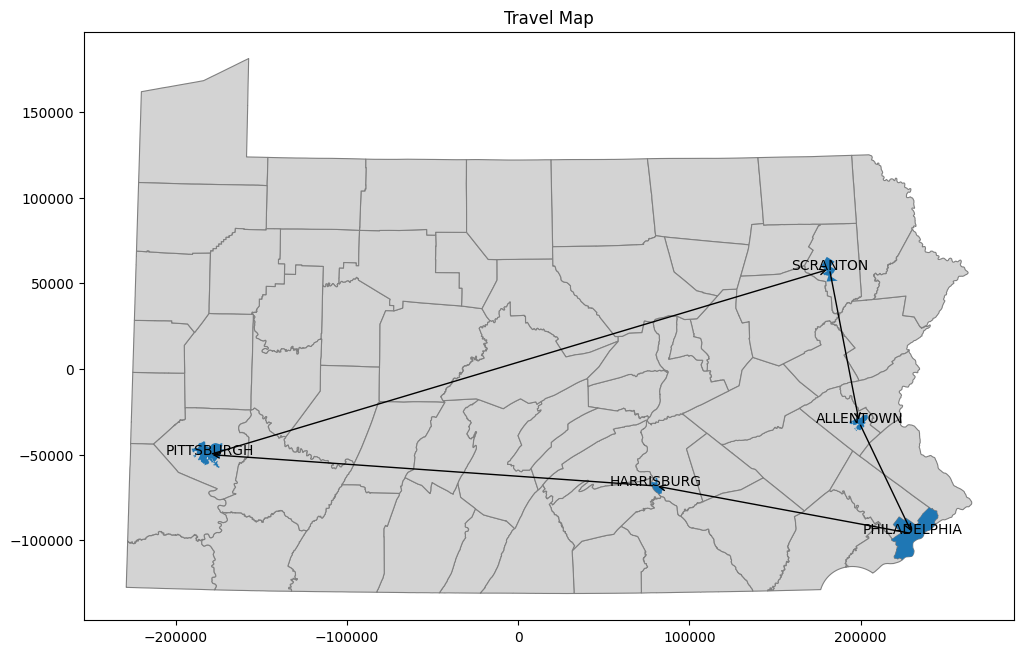

In [43]:
# Overlaying plots of State and travel towns
fig, ax = plt.subplots(figsize=(12, 8))
county_ortho.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.8)
travel_ortho.plot(ax=ax)
ax.set_title("Travel Map")

# Connect the cities with lines and label them
for i in range(len(travel_towns) - 1):
    city1 = travel_ortho[travel_ortho["MUNICIPAL1"] == travel_towns[i]].iloc[0]
    city2 = travel_ortho[travel_ortho["MUNICIPAL1"] == travel_towns[i + 1]].iloc[0]

    x1, y1 = city1["coords"]
    x2, y2 = city2["coords"]

    # Draw arrows
    ax.annotate("",
                xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->"))
    
    # Label cities
    ax.text(x1, y1, travel_towns[i], ha="center")

In [45]:
# Centroids in ortho projection
travel_ortho["centroid"] = travel_ortho.geometry.centroid

# Total distance
total_distance_ortho = 0
for i in range(len(travel_towns) - 1):
    city1 = travel_ortho[travel_ortho["MUNICIPAL1"] == travel_towns[i]].iloc[0]
    city2 = travel_ortho[travel_ortho["MUNICIPAL1"] == travel_towns[i + 1]].iloc[0]
    
    total_distance_ortho += city1["centroid"].distance(city2["centroid"])

# Convert to Platte Carree projection (EPSG:4326)
travel_ortho_pc = travel_ortho.to_crs(epsg=4326)

# Centroids in Platte Carree projection
travel_ortho_pc["centroid"] = travel_ortho_pc.geometry.centroid

# Haversine function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    m = 6371000 * c  # Earth's radius in m
    return m

# Total travel distance using haversine
total_distance_haversine = 0
for i in range(len(travel_towns) - 1):
    city1 = travel_ortho_pc[travel_ortho_pc["MUNICIPAL1"] == travel_towns[i]].iloc[0]
    city2 = travel_ortho_pc[travel_ortho_pc["MUNICIPAL1"] == travel_towns[i + 1]].iloc[0]
    lon1, lat1 = city1["centroid"].x, city1["centroid"].y
    lon2, lat2 = city2["centroid"].x, city2["centroid"].y
    total_distance_haversine += haversine(lon1, lat1, lon2, lat2)

print(f"Total distance in ortho projection: {total_distance_ortho:.2f} meters")
print(f"Total distance using haversine: {total_distance_haversine:.2f} meters")

Total distance in ortho projection: 954747.36 meters
Total distance using haversine: 954915.62 meters


C:\Users\reyme\AppData\Local\Temp\ipykernel_5016\2447204209.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  travel_ortho_pc["centroid"] = travel_ortho_pc.geometry.centroid
